# NetPay (Net Gross Ratio)はCollocated cokrigingで作成

# Collocated cokrigingについて

* CokrigingとCollocated cokrigingは異なる点に注意

||Ordinary Kriging|Cokriging|Collocated cokriging|
|:--|:--|:--|:--|
|GSLIB|Ordinary Kriging (kb2d, kt3d)|Cokriging (COKB3D)|Collocated Kriging (COKB3D)|
|Builder|Ordinary Kriging|無し|Ordinary Kriging with 2ndary Variable|
|Petrel|Kriging & Kriging (GSLIB) |無し|Co-kriging tab|

* Collocated cokrigingの定義
* Hard data $X$は7坑井、Soft data $Y$は1点、重み$w$
* Soft dataはSoft dataの平均$m_{Y}$を引いて、Hard dataの平均$m_{X}$を足したものである
* 行列小さく、計算速い
$$
\begin{align}
X^{\star}(u_{0})=\sum_{i=1}^{7 well}w_{X_{i}} X(u_{i}) + w_{Y_{0}} [Y(u_{0})-m_{Y}+m_{X}]
\end{align}
$$


* Cokrigingの定義
* 今回は使用しない。
* GSLIBにおいて適切なVariogram (実対称行列、行列の定値性)を入力しないと、Coregionalizationの問題としてエラー
* Builder, Petrelではこの問題があり、Cokrigingは使われていないのか？
$$
\begin{align}
X^{\star}(u_{0})=\sum_{i=1}^{7 well}w_{X_{i}} X(u_{i}) + \sum_{k=1}^{m}w_{Y_{k}} Y(u_{k})
\end{align}
$$

# NGR Soft data

* Petrel(小松)で作成したProbability map: Range=0~1
* NGR soft dataのベース
* 新規Propertyを作成する方法が分からなかったため、ここではPermeabilityに保存

![](123.PNG)

# 坑井位置のNGR


![](NGR.PNG)

# NGR Hard data
* NGRのhard dataを入力
* Use layer number for 3D
* D Layer

![](hard.PNG)

# Oridinary Kriging with 2ndary Variable
* 2ndary Variable PropertyはNGR soft data (43040 point)
* Correlation Coefficent =0.5
* Search radii & Range=50,000 ft, Sill=1


* Correlation Coefficient==> -1から1
* 1 (or -1) will give all the Kriging weights to the secondary variable and none to the primary attribute (1==> 2ndary)
* 0 will give all the Kriging weights to the primary variable and none to the secondary attribute (0==> primary)

![](3.PNG)

# D層NGRマップ 
* 上: Soft data
* 中: Coefficient=0.5, Variogram=1
* 下: Coefficient=0.5, Variogram=1, Normarl Socre Transform

* 今回はCoefficient=0.5に統一
* Coefficient=1の場合、Soft dataのみに重みがかかる
* Coefficient=0の場合、Hard dataのみに重みがかかる


## Cokrigingで値が大きくなる理由
* $Y(u_{0})-m_{Y}+m_{X}$の計算で調整されるため
* $m_{Y}$ : soft data平均
* $m_{X}$ : hard data平均

$$
\begin{align}
X^{\star}(u_{0})=\sum_{i=1}^{7 well}w_{X_{i}} X(u_{i}) + w_{Y_{0}} [Y(u_{0})-m_{Y}+m_{X}]
\end{align}
$$

## Normal Score Transformの影響
* 分からない。

![](D.PNG)

# E層NGRマップ
* 上: Soft data
* 中: Coefficient=0.5, Variogram=1
* 下: Coefficient=0.5, Variogram=1, Normarl Socre Transform
![](E.PNG)

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os

%matplotlib inline

# Grid
* NX=160, NY=269 (=43,040)
* 1grid =50m
* 8000m, 13450m
* 26246ft, 44127 ft

In [2]:
NX=160
NY=269
Xmeter=NX*50
Ymeter=NY*50
Xfeet=NX*50*3.28084
Yfeet=NY*50*3.28084
print (Xmeter, Ymeter, Xfeet, Yfeet)

8000 13450 26246.72 44127.298


# 中段NGR: Coefficient=0.5, Variogram=1の読み込み

In [3]:
with open("NGR-non-normal.txt", "r") as f:
    a = f.read().split(' ')

b=pd.Series(a)
c=pd.DataFrame({
        'ngr':pd.to_numeric(b, errors='coerce')       
    })
NGR=c[c.ngr>=0].reset_index(drop=True)
NGR=NGR.assign(
    z=NGR.index//(160*269)+1,
)

# 再度、中段NGR: Coefficient=0.5, Variogram=1をプロット

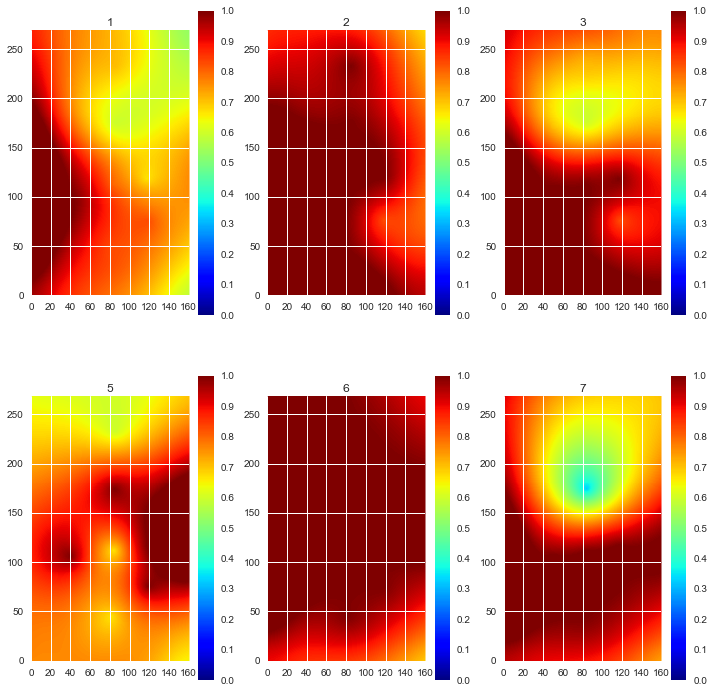

In [4]:
plt.figure(figsize=(12,12))
for n, g in zip([231, 232, 233, 234, 235, 236], [1, 2, 3, 5, 6, 7]): 
    plt.subplot(n)
    graph=NGR[NGR.z==g].ngr.reshape(NY,NX)
    plt.imshow(graph, interpolation='nearest', cmap='jet', vmin = 0.0, vmax = 1.0)
        
    plt.xlim(0,NX)
    plt.ylim(0,NY)    
    plt.colorbar()
    plt.title(g)

In [5]:
hard=pd.read_csv(r'hard\hard_all.txt')
hard.poro = hard.poro.round(2)
hard.ngr = hard.ngr.round(4)
hard.head(3)

#softori=pd.read_csv(r'soft\rotsoft_all.txt')
softori=pd.read_csv(r'soft\rotsoft_all_eye2.txt')
softori.poro=softori.poro.round(2)
softori.ngr=softori.ngr.round(4)
softori.thickness=softori.thickness.round(4)

softori['I']=(softori.index - (softori.z-1)*NX*NY) % NX
softori['J']=(softori.index - (softori.z-1)*NX*NY) // NX
len(softori.z==1)

301280

# Gross thickness

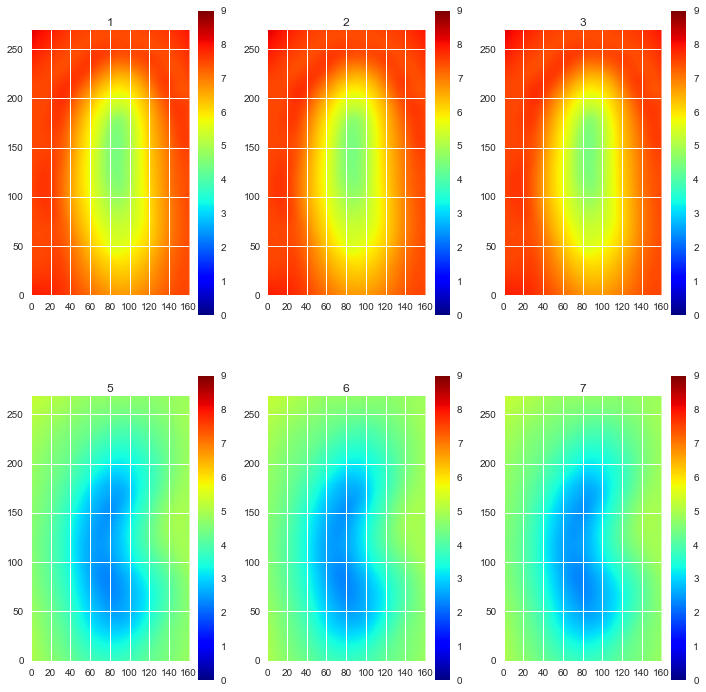

In [6]:
plt.figure(figsize=(12,12))
for n, g in zip([231, 232, 233, 234, 235, 236], [1, 2, 3, 5, 6, 7]):
    plt.subplot(n)
    graph=softori[softori.z==g].thickness.reshape(NY,NX)

    plt.imshow(graph, interpolation='nearest', cmap='jet', vmin = 0.0, vmax = 9)
    plt.xlim(0,NX)
    plt.ylim(0,NY)    
    plt.colorbar()
    plt.title(g)

# Net Pay
* NetPay = Gross thickness * NGR

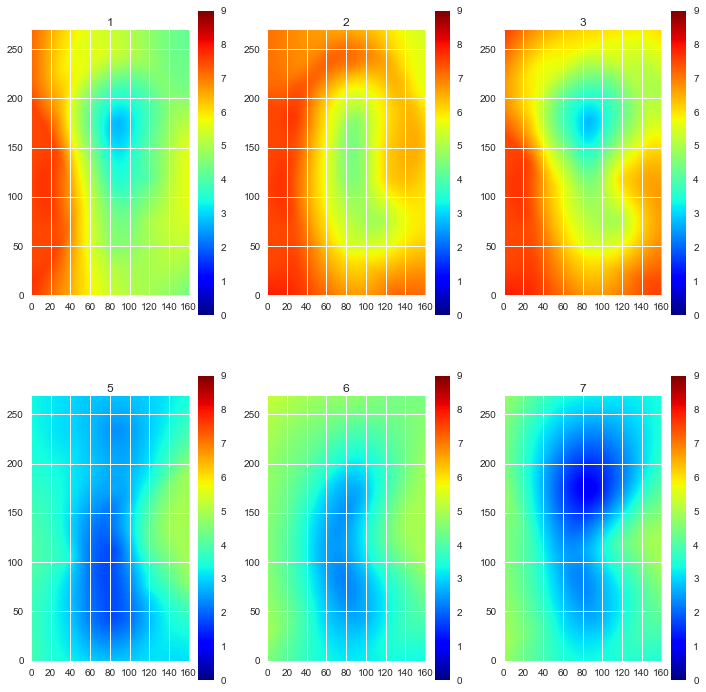

In [7]:
plt.figure(figsize=(12,12))
for n, g in zip([231, 232, 233, 234, 235, 236], [1, 2, 3, 5, 6, 7]):
    plt.subplot(n)
    g1=softori[softori.z==g].thickness
    g2=NGR[NGR.z==g].ngr
    graph=g1*g2
    graph=graph.reshape(NY,NX)

    plt.imshow(graph, interpolation='nearest', cmap='jet', vmin = 0.0, vmax = 9)
    plt.xlim(0,NX)
    plt.ylim(0,NY)    
    plt.colorbar()
    plt.title(g)

# NetPay出力

In [8]:
g1=softori.thickness
g2=NGR.ngr
netpay=g1*g2
netpay.to_csv(r'netpay_all.txt', index=False)

# D, E和

$$
\begin{align}
NGR (D) = \sum_{i=1}^{3} NGR
\end{align}
$$

$$
\begin{align}
NGR (E) = \sum_{i=5}^{7} NGR
\end{align}
$$

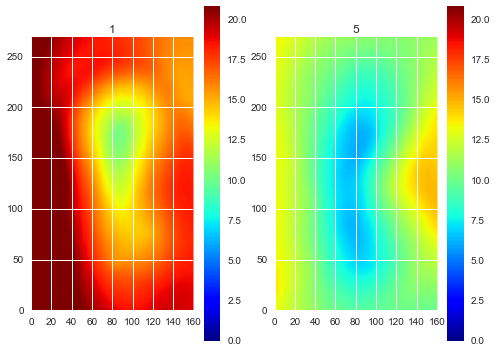

In [9]:
plt.figure(figsize=(8,6))
for n, g in zip([121, 122], [1, 5]):
    plt.subplot(n)
    gs1=softori[softori.z==g].thickness.reshape(NY,NX)
    gs2=softori[softori.z==g+1].thickness.reshape(NY,NX)
    gs3=softori[softori.z==g+2].thickness.reshape(NY,NX)
    
    ngr1=NGR[NGR.z==g].ngr.reshape(NY,NX)
    ngr2=NGR[NGR.z==g+1].ngr.reshape(NY,NX)
    ngr3=NGR[NGR.z==g+2].ngr.reshape(NY,NX)
    graph=gs1*ngr1+gs2*ngr2+gs3*ngr3

    plt.imshow(graph, interpolation='nearest', cmap='jet', vmin = 0.0, vmax = 20.8)
    plt.xlim(0,NX)
    plt.ylim(0,NY)    
    plt.colorbar()
    plt.title(g)

![](NETPYA2012.PNG)

# 坑井位置でのCollocated cokriging NGRのチェック

In [10]:
with open("NGR-non-normal.txt", "r") as f:
    a = f.read().split(' ')

b=pd.Series(a)
c=pd.DataFrame({
        'ngr':pd.to_numeric(b, errors='coerce')       
    })
checkngr=c[c.ngr>=0].reset_index(drop=True)

print(len(checkngr))
print(160*269*7)

def sc(J, i, j):
    z1=checkngr.loc[160*269*(1-1)+ 160*(j-1)+i-1, 'ngr']
    z2=checkngr.loc[160*269*(2-1)+ 160*(j-1)+i-1, 'ngr']
    z3=checkngr.loc[160*269*(3-1)+ 160*(j-1)+i-1, 'ngr']
    z4=checkngr.loc[160*269*(4-1)+ 160*(j-1)+i-1, 'ngr']
    z5=checkngr.loc[160*269*(5-1)+ 160*(j-1)+i-1, 'ngr']
    z6=checkngr.loc[160*269*(6-1)+ 160*(j-1)+i-1, 'ngr']
    z7=checkngr.loc[160*269*(7-1)+ 160*(j-1)+i-1, 'ngr']

    s=  pd.Series([z1, z2, z3, z4, z5, z6, z7])
    return   pd.DataFrame({J: s})

test=pd.concat([sc('J1', 84, 113),sc('J2', 85, 175), sc('J3',118, 76), sc('J4',86, 233), sc('J5',41, 107), sc('J6',117, 119), sc('J7',82, 46)], axis=1) 
test.index=list('1234567')
checkn=test

checkn

301280
301280


,J1,J2,J3,J4,J5,J6,J7
1,0.80,0.60,0.83,0.71,1.0,0.67,0.83
2,1.00,1.00,0.83,1.00,1.0,1.00,1.00
3,1.00,0.60,0.83,0.71,1.0,1.00,1.00
4,0.00,0.00,0.00,0.00,0.0,0.00,0.00
5,0.67,1.00,1.00,0.60,1.0,1.00,0.67
6,1.00,1.00,1.00,1.00,1.0,1.00,1.00
7,1.00,0.33,1.00,0.60,1.0,1.00,1.00


![](NGR.PNG)